In [10]:
from scipy.stats import wasserstein_distance
import matplotlib.pyplot as plt
import pandas as pd
import numpy  as np
import control as ctl

In [11]:
target  = pd.read_pickle('files/Target.pkl')
desired = pd.read_pickle('files/Desired.pkl')
display(target.head())
display(desired.head())

,time,s2,s1
0,0.00,"{'ax': -0.08379706, 'ay': -0.6105214, 'wz': 0....","{'ax': -0.09816227, 'ay': -0.581791, 'wz': 0.0..."
1,0.06,"{'ax': -0.1651999, 'ay': -0.581791, 'wz': 0.01...","{'ax': -0.09816227, 'ay': -0.5722142, 'wz': 0...."
2,0.06,"{'ax': -0.1651999, 'ay': -0.581791, 'wz': 0.01...","{'ax': -0.09816227, 'ay': -0.5722142, 'wz': 0...."
3,0.08,"{'ax': -0.07900865, 'ay': -0.6847417, 'wz': 0....","{'ax': -0.05506664, 'ay': -1.223437, 'wz': 0.0..."
4,0.10,"{'ax': -0.04309563, 'ay': -0.5865794, 'wz': 0....","{'ax': -0.07900865, 'ay': -0.5770026, 'wz': 0...."


,pitch,roll,yaw,wx,wy,wz,ax,ay,az,time
0,0.0,0.0,0.0,1.0,2.0,-3.0,-100.0,-54.0,484.0,0.00
1,0.0,0.0,0.0,1.0,2.0,-3.0,-100.0,-54.0,484.0,0.06
2,0.0,0.0,0.0,1.0,2.0,-3.0,-100.0,-54.0,484.0,0.06
3,0.0,0.0,0.0,1.0,2.0,-3.0,-100.0,-54.0,484.0,0.08
4,0.0,0.0,0.0,1.0,2.0,-3.0,-100.0,-54.0,484.0,0.10


# ANÁLISE

In [13]:
sensor = 's1'
key    = 'ax'

time = target.time.values
yTarget  = np.array([s[key] for s in target[sensor]])
yDesired = np.array(desired[key])

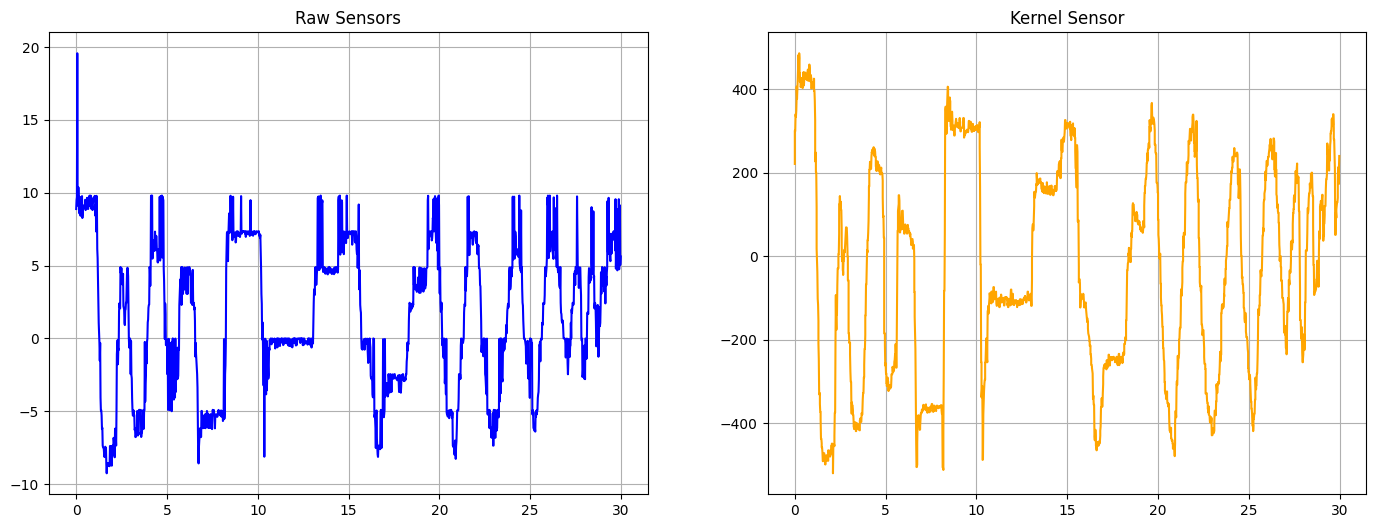

In [ ]:
plt.figure(figsize=(17, 5))
plt.subplot(1, 2, 1)
plt.plot(time, yTarget, color='blue')
plt.title('Raw Sensors')
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(time, yDesired, color='orange')
plt.title('Kernel Sensor')
plt.grid()

- Comparação normalizada com erro relacionado à distancia entre os pontos

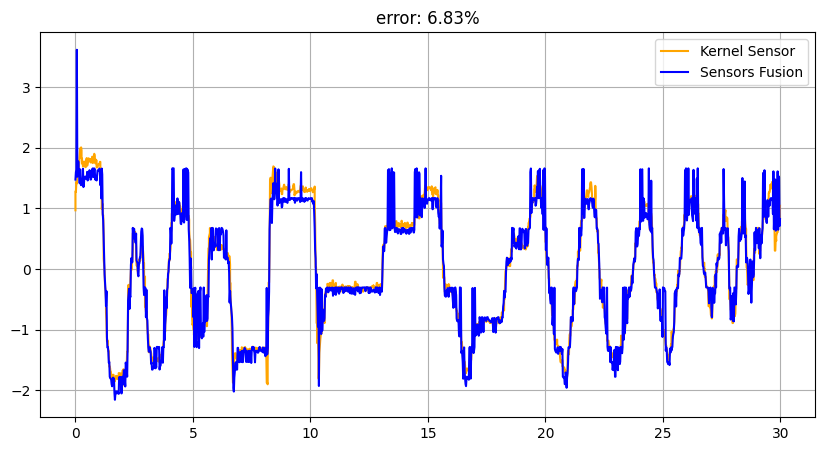

In [15]:
def normalize(data):
    return np.array(data - np.mean(data))/np.std(data)

def compare(data1, data2):
    data1 = normalize(data1)
    data2 = normalize(data2)
    score = wasserstein_distance(data1, data2)
    return data1, data2, score


d, t, score = compare(yDesired, yTarget)
plt.figure(figsize=(10, 5))
plt.plot(time, d, color='orange', label='Kernel Sensor')
plt.plot(time, t, color='blue',  label='Sensors Fusion')
plt.title(f'error: {score*100:.2f}%')
plt.legend(), plt.grid()
plt.show()

# FILTRO DIGITAL

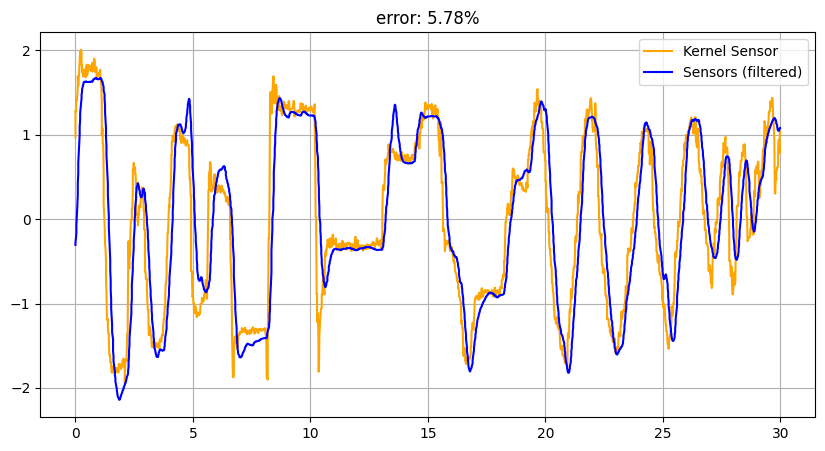

In [16]:
class LaplaceFilter:
    num = []
    den = []
    
    def __init__(self, Ts=1.0, UP=0.1, dt=0.05, Tp=None):
        zeta = -np.log(UP)/np.sqrt(np.pi**2 + np.log(UP)**2)
        Wn   = 4/(zeta*Ts)

        if Tp is not None:
            Wn = np.pi/(Tp*np.sqrt(1 - zeta**2))

        s = ctl.TransferFunction.s
        C = Wn**2/(s**2 + 2*zeta*Wn*s + Wn**2)

        C_z = ctl.c2d(C, dt, method='tustin')
        self.num, self.den = self.getFraction(C_z)
        self.Xn = np.zeros_like(self.num)
        self.Yn = np.zeros_like(self.den)
        self.dt = dt

    def getFraction(self, G_z):
        num, den = ctl.tfdata(G_z)
        num = np.squeeze(num)
        den = np.squeeze(den)

        num = num/den[0]
        den = den/den[0]

        if type(num) == np.float64:
            num = np.array([num])

        num = [float(val) for val in num]
        den = [float(val) for val in den]
        return (num, den) 

    def compute(self):
        out = 0.0

        for i in range(0, len(self.num)):
            out += self.Xn[i]*(self.num[i])
        
        for i in range(1, len(self.den)):
            out += self.Yn[i]*(-1*self.den[i])

        return out

    def update(self, input):
        for n in range(len(self.num)-1, 0, -1):
            self.Xn[n] = self.Xn[n-1]

        for n in range(len(self.den)-1, 0, -1):
            self.Yn[n] = self.Yn[n-1]
        
        self.Xn[0] = input
        self.Yn[0] = self.compute()
        return self.Yn[0]
    
    def getout(self):
        out = ''
        
        for i in range(0, len(self.num)): 
            out += f'self.Xn{i}*({self.num[i]:.6f}) + '

        for i in range(1, len(self.den)): 
            out += f'self.Yn{i}*({-1*self.den[i]:.6f}) + '
        
        out = out.replace('Xn0', 'Xn')[:-3].replace('self.Xn*', 'Xn*')
        print(out)
        return out
    
    def reset(self):
        self.Xn1 = self.Xn2 = 0.0
        self.Yn1 = self.Yn2 = 0.0

    def apply(self, data):
        self.reset()
        return [self.update(val) for val in data]


dt     = 0.02
filter = LaplaceFilter(Ts=0.8, UP=0.02, dt=dt)
d, t, score = compare(yDesired, filter.apply(yTarget))

plt.figure(figsize=(10, 5))
plt.plot(time, d, color='orange', label='Kernel Sensor')
plt.plot(time, t, color='blue',  label='Sensors (filtered)')
plt.title(f'error: {score*100:.2f}%')
plt.legend(), plt.grid()
plt.show()

# COMPARAÇÕES

In [19]:
stored = {}

<Figure size 1700x1000 with 0 Axes>

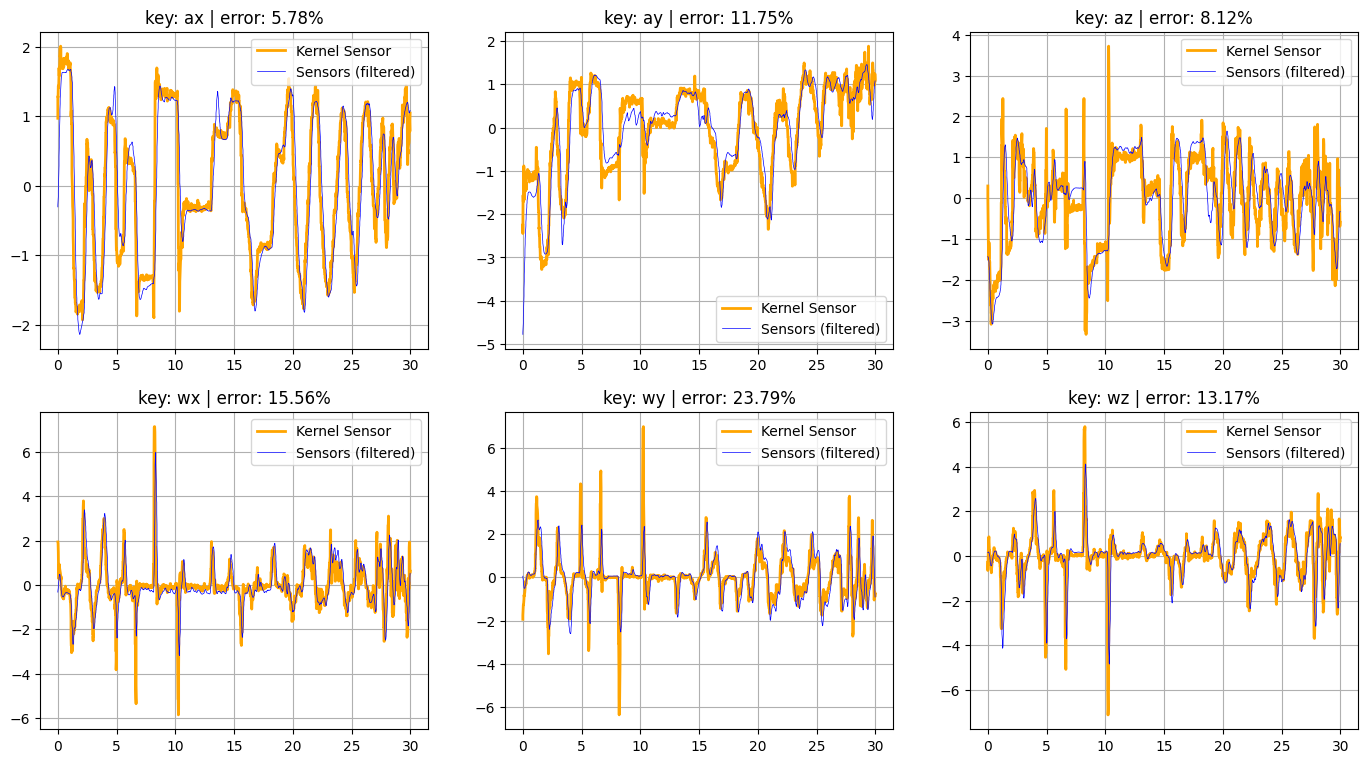

In [17]:
plt.figure(figsize=(17, 10))
sensor = 's1'
ts_accel = 0.80
ts_omega = 0.50

values = {
    'ax': LaplaceFilter(Ts=ts_accel, UP=0.02, dt=dt).apply([s['ax'] for s in target[sensor]]),
    'ay': LaplaceFilter(Ts=ts_accel, UP=0.02, dt=dt).apply([s['ay'] for s in target[sensor]]),
    'az': LaplaceFilter(Ts=ts_accel, UP=0.02, dt=dt).apply([s['az'] for s in target[sensor]]),

    'wx': LaplaceFilter(Ts=ts_omega, UP=0.02, dt=dt).apply([s['wx'] for s in target[sensor]]),
    'wy': LaplaceFilter(Ts=ts_omega, UP=0.02, dt=dt).apply([s['wy'] for s in target[sensor]]),
    'wz': LaplaceFilter(Ts=ts_omega, UP=0.02, dt=dt).apply([s['wz'] for s in target[sensor]]),
}

plt.figure(figsize=(17, 14))
stored[sensor] = values
index = 0

for key, data in values.items():
    d, t, score = compare(desired[key], data)
    index = index + 1

    plt.subplot(3, 3, index)
    plt.plot(desired.time, d, color='orange', label='Kernel Sensor', linewidth=2)
    plt.plot(desired.time, t, color='blue',  label='Sensors (filtered)', linewidth=.5)
    plt.title(f'key: {key} | error: {score*100:.2f}%')
    plt.legend(), plt.grid()

<Figure size 1700x1000 with 0 Axes>

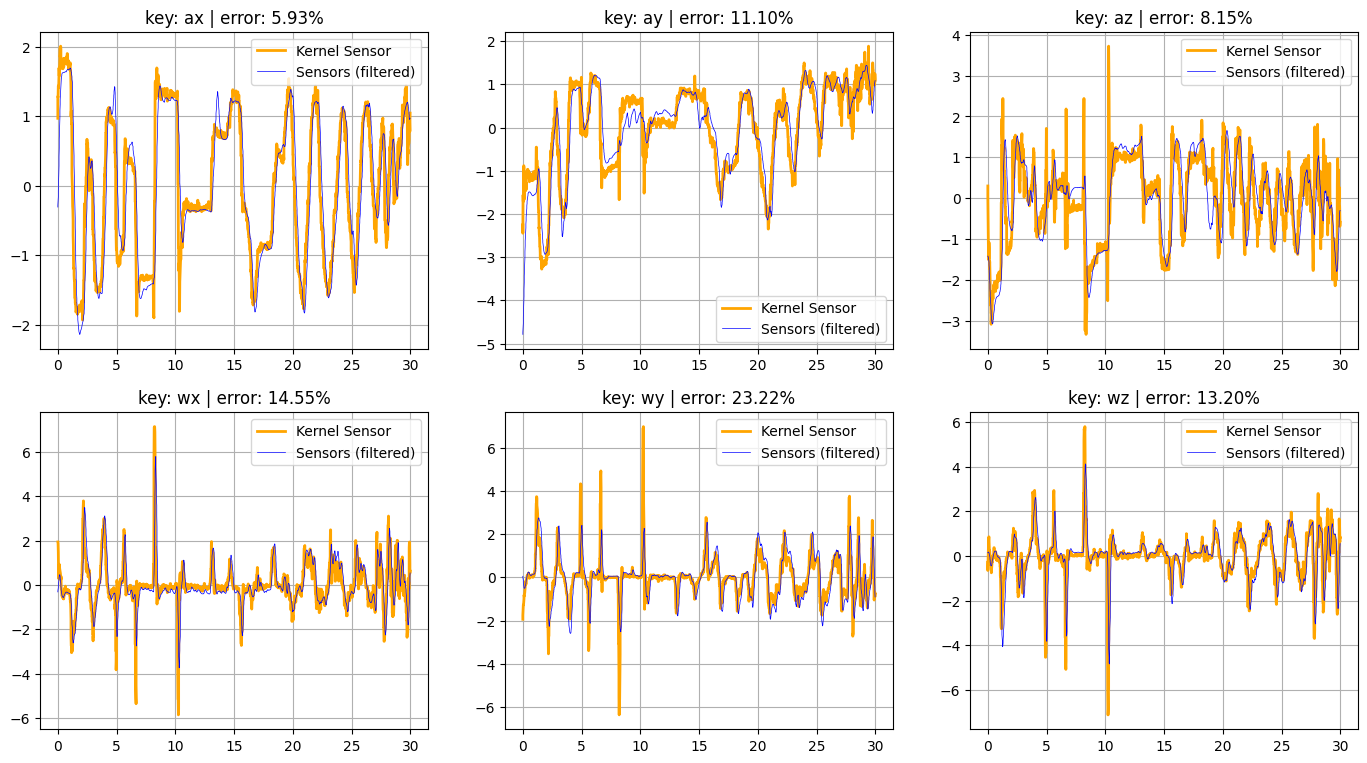

In [18]:
plt.figure(figsize=(17, 10))
sensor = 's2'
ts_accel = 0.80
ts_omega = 0.50

values = {
    'ax': LaplaceFilter(Ts=ts_accel, UP=0.02, dt=dt).apply([s['ax'] for s in target[sensor]]),
    'ay': LaplaceFilter(Ts=ts_accel, UP=0.02, dt=dt).apply([s['ay'] for s in target[sensor]]),
    'az': LaplaceFilter(Ts=ts_accel, UP=0.02, dt=dt).apply([s['az'] for s in target[sensor]]),

    'wx': LaplaceFilter(Ts=ts_omega, UP=0.02, dt=dt).apply([s['wx'] for s in target[sensor]]),
    'wy': LaplaceFilter(Ts=ts_omega, UP=0.02, dt=dt).apply([s['wy'] for s in target[sensor]]),
    'wz': LaplaceFilter(Ts=ts_omega, UP=0.02, dt=dt).apply([s['wz'] for s in target[sensor]]),
}

plt.figure(figsize=(17, 14))
stored[sensor] = values
index = 0

for key, data in values.items():
    d, t, score = compare(desired[key], data)
    index = index + 1

    plt.subplot(3, 3, index)
    plt.plot(desired.time, d, color='orange', label='Kernel Sensor', linewidth=2)
    plt.plot(desired.time, t, color='blue',  label='Sensors (filtered)', linewidth=.5)
    plt.title(f'key: {key} | error: {score*100:.2f}%')
    plt.legend(), plt.grid()

# SALVANDO

In [ ]:
for i in range(len(target)):
    row = target.iloc[i]

    for sensor in stored.keys():
        for key in stored[sensor].keys():
            row[sensor][key] = stored[sensor][key][i]

target.head()

In [ ]:
target.to_pickle('../C - Fusion/files/Target.pkl')
desired.to_pickle('../C - Fusion/files/Desired.pkl')